In [1]:
# Ignore warnings
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# Import required libraries
import pickle
import cv2
import os
from keras.applications import ResNet50,VGG16
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D
from tensorflow.python.keras.layers.convolutional import MaxPooling2D,AveragePooling2D
from tensorflow.python.keras.layers.core import Activation, Flatten, Dropout, Dense
from tensorflow.python.keras.layers import TimeDistributed,LSTM,Bidirectional
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt

In [3]:
# Defining shape of data
inputShape = (128,128,3)
# initial learning rate
INIT_LR = 0.001
# Number of epochs
EPOCHS = 10
chanDim = -1

# Data Preprocessing

## Stpes for preprocessing :
1. Loading Image
2. Reshaping image
3. Removing noise (Gaussian Blur)
4. Applying heatmap

In [4]:
def process(image_path):
    # Reading images
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    # resize image
    img= cv2.resize(img, inputShape[0:2], interpolation=cv2.INTER_LINEAR)
    # Gaussian Blurring
    img = cv2.GaussianBlur(img, (3,3), 0)
    # Applying heatmap
    img = cv2.applyColorMap(img, cv2.COLORMAP_HOT)
    
    return img

In [5]:
train_path = r"D:Project\Training"
test_path = r"D:Project\Test"
output_path_train = "Training_processed/"
output_path_test = "Test_processed/"

In [6]:
if os.path.isdir("Training_processed"):
    if os.path.isdir("Training_processed/Fire"):
        pass
    if os.path.isdir("Training_processed/No_Fire"):
        pass
else :
    os.mkdir("Training_processed")
    os.mkdir("Training_processed/Fire")
    os.mkdir("Training_processed/No_Fire/")
    
if os.path.isdir("Test_processed"):
    if os.path.isdir("Test_processed/Fire"):
        pass
    if os.path.isdir("Test_processed/No_Fire"):
        pass
else :
    os.mkdir("Test_processed")
    os.mkdir("Test_processed/Fire")
    os.mkdir("Test_processed/No_Fire/")

In [7]:
# Fire or no fire on Train data
for files in os.listdir(train_path):
    current_path = train_path + '/'+files
    for image in os.listdir(current_path):
        img_path = current_path+"/"+image
        processed_iamge = process(img_path)
        
        save_path = output_path_train+"/"+files+"/"+image
        cv2.imwrite(save_path,processed_iamge)

In [8]:
# Fire or no fire on Test data
for files in os.listdir(test_path):
    current_path = test_path + '/'+files
    for image in os.listdir(current_path):
        img_path = current_path+"/"+image
        processed_iamge = process(img_path)
        
        save_path = output_path_test+"/"+files+"/"+image
        cv2.imwrite(save_path,processed_iamge)

### Loading Train Data

In [9]:
def plot(hist,name):
    # Number of points
    num_epoch = [i for i in range(EPOCHS)]
    # Creating a figure
    plt.figure(figsize=(15,5))
    # Plot tilte
    plt.title("{} on Original Data :: ".format(name))
    # Subplot 1
    plt.subplot(121)
    plt.title("Accuracy")
    # Plot train accuracy
    plt.plot(num_epoch,hist.history["accuracy"],label="train")
    # Plot validation accuracy
    plt.plot(num_epoch,hist.history["val_accuracy"],label="validation")
    plt.legend(loc="best")
    # Subplot 2
    plt.subplot(122)
    plt.title("Loss")
    # PLot train Accuracy
    plt.plot(num_epoch,hist.history["loss"],label="train")
    # Plot validation Accuracy
    plt.plot(num_epoch,hist.history["val_loss"],label="validation")
    plt.legend(loc="best")
    plt.show()

In [10]:
# Create image data generator
data_gen = ImageDataGenerator()

In [11]:
# train data
train_data = data_gen.flow_from_directory(directory = r"D:Project\Training_processed",
                                                target_size=(128,128),
                                                batch_size=4,
                                                class_mode='categorical',
                                                shuffle=True)
# validation data
val_data = data_gen.flow_from_directory(directory = r"D:\Project\Test_processed",
                                                target_size=(128,128),
                                                batch_size=1,
                                                class_mode='categorical',
                                                shuffle=True)

Found 39375 images belonging to 2 classes.
Found 8617 images belonging to 2 classes.


# Custom CNN

In [12]:
class CNN():
    def build(self):
        model = Sequential()
        # 1st Block
        model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape,activation="relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(3, 3)))
        model.add(Dropout(0.25))
        # 2nd Block
        model.add(Conv2D(64, (3, 3), padding="same",activation="relu"))
        model.add(BatchNormalization(axis=chanDim))
        # 3rd Block
        model.add(Conv2D(64, (3, 3), padding="same",activation="relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        # 4th Bolck
        model.add(Conv2D(128, (3, 3), padding="same",activation="relu"))
        model.add(BatchNormalization(axis=chanDim))
        # 5th Block
        model.add(Conv2D(128, (3, 3), padding="same",activation="relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        # 6th Block
        model.add(Flatten())
        model.add(Dense(1024,activation="relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        # 7th Block
        model.add(Dense(512,activation="relu"))
        model.add(BatchNormalization())
        # OutPut Block
        model.add(Dense(2,activation="softmax"))
        
        return model

In [13]:
# Define and build custom CNN model
model = CNN()
model = model.build()
# Define Optimizer
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# compile model
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")
historyPro = model.fit(train_data,epochs=EPOCHS,validation_data = val_data)

[INFO] training network...
Epoch 1/10
9844/9844 [==============================] - 2895s 294ms/step - loss: 0.3161 - accuracy: 0.8948 - val_loss: 1.7117 - val_accuracy: 0.4865
Epoch 2/10
9844/9844 [==============================] - 2992s 304ms/step - loss: 0.1589 - accuracy: 0.9575 - val_loss: 3.0584 - val_accuracy: 0.5461
Epoch 3/10
9844/9844 [==============================] - 2904s 295ms/step - loss: 0.1160 - accuracy: 0.9702 - val_loss: 4.3105 - val_accuracy: 0.5935
Epoch 4/10
9844/9844 [==============================] - 2947s 299ms/step - loss: 0.0954 - accuracy: 0.9789 - val_loss: 4.0060 - val_accuracy: 0.5802
Epoch 5/10
9844/9844 [==============================] - 2863s 291ms/step - loss: 0.0895 - accuracy: 0.9796 - val_loss: 4.1997 - val_accuracy: 0.5432
Epoch 6/10
9844/9844 [==============================] - 2857s 290ms/step - loss: 0.0939 - accuracy: 0.9775 - val_loss: 3.4004 - val_accuracy: 0.5459
Epoch 7/10
9844/9844 [==============================] - 2863s 291ms/step - loss

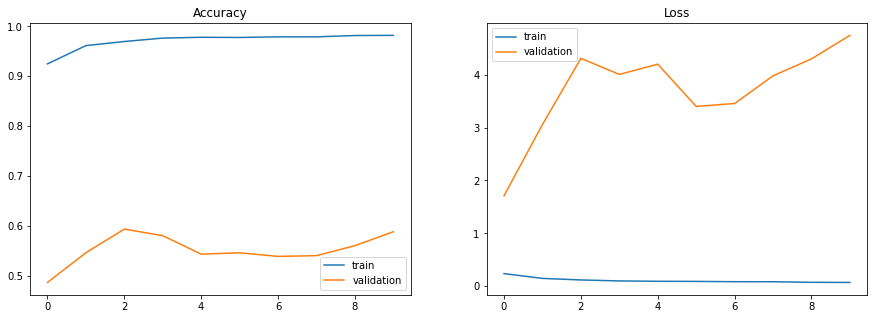

In [14]:
# plot values
plot(historyPro,"CNN")

# Resnet50

In [15]:
# Load Architechture
model_resnet = ResNet50(include_top=True, weights=None,input_shape =inputShape, classes = 2)

In [16]:
model_resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
# Define optimizer
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# Compile mOdel
model_resnet.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")
history_processed = model_resnet.fit(train_data,epochs=EPOCHS,validation_data = val_data)

[INFO] training network...
Epoch 1/10
9844/9844 [==============================] - 7684s 780ms/step - loss: 0.2618 - accuracy: 0.9347 - val_loss: 2.1371 - val_accuracy: 0.5552
Epoch 2/10
2286/9844 [=====>........................] - ETA: 1:36:02 - loss: 0.0519 - accuracy: 0.9845

In [ ]:
plot(history_processed,"ResNet50")